Assignment 10 Supplementary: Semantic Search Demo
===============

This Python notebook guides you through the code for Text-to-Image and Image-to-Image search.

Prior to starting, you should have a file called `image_embeddings.pickle` and a file called `coco_images_resized.zip` in the current directory.

First, unzip `coco_images_resized.zip`. This directory contains the images that you will search through.

This assignment uses pretrained CLIP (Contrastive Language Image Pretrained) models to embed text and images into a joint embedding space. You can read about CLIP models here: https://www.pinecone.io/learn/clip-image-search/

**Your end goal is to find the most relevant images given either an image or a text query.**

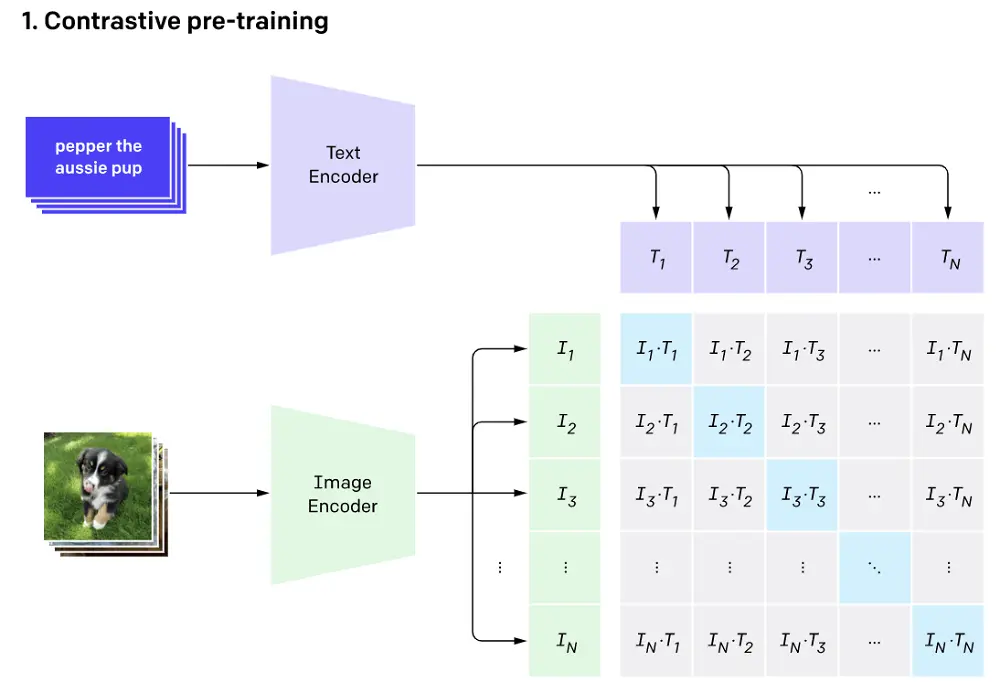

### Step 1: Caclulate Image Embeddings for Dataset

We first want to make our image database easily searchable. To achieve this, we calculate the image embedding for each image using the image encoder. **This has already been done for you,** because it is computationally intensive. Below is the code for reference.

In [5]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 2.6 MB/s eta 0:00:002.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 2.3 MB/s eta 0:00:00? eta -:--:--

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install open_clip

ERROR: Could not find a version that satisfies the requirement open_clip (from versions: none)
ERROR: No matching distribution found for open_clip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install open-clip-torch

  Using cached open_clip_torch-2.29.0-py3-none-any.whl.metadata (31 kB)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached huggingface_hub-0.26.5-py3-none-any.whl.metadata (13 kB)
  Using cached timm-1.0.12-py3-none-any.whl.metadata (51 kB)
Using cached open_clip_torch-2.29.0-py3-none-any.whl (1.5 MB)
Using cached ftfy-6.3.1-py3-none-any.whl (44 kB)
Using cached huggingface_hub-0.26.5-py3-none-any.whl (447 kB)
Using cached timm-1.0.12-py3-none-any.whl (2.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from open_clip import create_model_and_transforms, tokenizer
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# Configuration
device = "mps" if torch.backends.mps.is_available() else "cpu"  # Use MPS for Apple Silicon, else CPU
model_name = "ViT-B/32"
pretrained = "openai"
batch_size = 32
image_folder = "coco_images_resized"
max_images = 10000  # Process only the first 5,000 images

# Load model and preprocess function
model, preprocess_train, preprocess_val = create_model_and_transforms(model_name, pretrained=pretrained)
model = model.to(device)
model.eval()

# Image transformations (lightweight)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Collect and slice image paths
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))][:max_images]
print(f"Number of images to process: {len(image_paths)}")

# Function to preprocess a single image
def preprocess_image(path):
    try:
        image = Image.open(path).convert("RGB")
        return transform(image)
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None

# Function to load images in parallel
def load_images_parallel(batch_paths):
    with ThreadPoolExecutor() as executor:
        images = list(executor.map(preprocess_image, batch_paths))
    images = [img for img in images if img is not None]
    return torch.stack(images) if images else None

# DataFrame to store results
results = []
embeddings_list = []

# Process images in batches
with torch.no_grad():
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing images"):
        batch_paths = image_paths[i:i + batch_size]
        images = load_images_parallel(batch_paths)
        if images is None:
            continue

        images = images.to(device)
        embeddings = model.encode_image(images)
        embeddings = F.normalize(embeddings, p=2, dim=1)

        results.extend([os.path.basename(path) for path in batch_paths])
        embeddings_list.append(embeddings.cpu().numpy())

# Create DataFrame
all_embeddings = np.vstack(embeddings_list)
df = pd.DataFrame({"file_name": results, "embedding": list(all_embeddings)})

# Save results
df.to_pickle('image_embeddings.pickle')


Number of images to process: 10000


Processing images: 100%|██████████| 313/313 [01:37<00:00,  3.21it/s]


Run the code below to examine the dataframe.

The dataframe `df` has two columns. The first column is the image file in the dataset folder. The second column is the image embedding corresponding to that image.

In [14]:
import pandas as pd
df = pd.read_pickle('image_embeddings.pickle')
df

,file_name,embedding
0,COCO_train2014_000000223373.jpg,"[0.0022347318, 0.016386718, 0.030752847, -0.01..."
1,COCO_train2014_000000460005.jpg,"[0.009293054, 0.017454492, -0.01773971, -0.017..."
2,COCO_train2014_000000485937.jpg,"[0.022950107, -0.015198072, 0.023924995, 0.013..."
3,COCO_train2014_000000477579.jpg,"[0.004330093, 0.0018419242, -0.025404504, 0.02..."
4,COCO_train2014_000000215819.jpg,"[0.009428469, -0.013251883, 0.008149387, -0.01..."
...,...,...
9995,COCO_train2014_000000158747.jpg,"[-0.067919545, 0.011691493, 0.0018313432, 0.05..."
9996,COCO_train2014_000000140108.jpg,"[-0.032358207, -0.004368518, -0.0038272806, 0...."
9997,COCO_train2014_000000005326.jpg,"[0.024348432, 0.00824117, 0.0005452893, 0.0020..."
9998,COCO_train2014_000000179951.jpg,"[-0.014570848, -0.0026482514, -0.024563108, 0...."


### Step 2: Image-to-Image Search

Now you will write some code to find the closest image in the dataset to a given image query.

Find a random image off the internet. Use the CLIP image encoder to encode the image; let's call this the `query_embedding`.

Now, display the image in the dataset that has the **maximum cosine similarity with the query embedding.**

**It is very important that you use the `ViT-B/32, openai` version of the CLIP model** to be consistent with the embeddings you were given.

Here's the documentation for CLIP: https://github.com/mlfoundations/open_clip

**Hint:** Take advantage of the code given to you at the bedginning of this assignment.

In [3]:
! pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.9 MB/s eta 0:00:000m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.8/447.8 kB 6.7 MB/s eta 0:00:001 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.0/392.0 kB 4.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 3.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.4 MB/s eta 0:00:00m eta 0:00:010:00:01


This is my query image


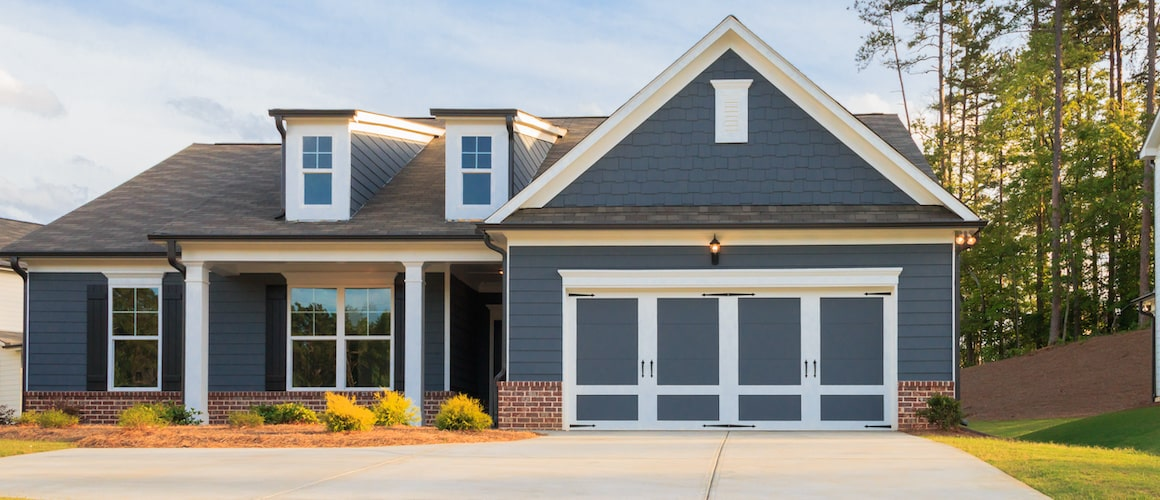

In [15]:
from IPython.display import Image
print('This is my query image')
Image(filename="house.jpg")

In [16]:
from PIL import Image
from open_clip import create_model_and_transforms, tokenizer
import torch.nn.functional as F

model, _, preprocess = create_model_and_transforms('ViT-B/32', pretrained='openai')

# This converts the image to a tensor
image = preprocess(Image.open("house.jpg")).unsqueeze(0)

# This calculates the query embedding
query_embedding = F.normalize(model.encode_image(image))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/open_clip/factory.py:372: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [19]:
import numpy as np

# Assume `query_embedding` is already computed and normalized
# query_embedding = F.normalize(model.encode_image(image), p=2, dim=1)

# Convert query_embedding to a NumPy array
query_embedding_np = query_embedding.squeeze().detach().cpu().numpy()

# Convert DataFrame embeddings to a NumPy array for efficient computation
embeddings = np.stack(df['embedding'].to_numpy())  # Shape: (num_images, embedding_dim)

# Compute cosine similarities
cosine_similarities = np.dot(embeddings, query_embedding_np)

# Find the index of the maximum similarity
max_index = np.argmax(cosine_similarities)

# Retrieve the corresponding image path
impath = os.path.join(image_folder, df.iloc[max_index]['file_name'])
print(f"Most similar image: {impath}")


Most similar image: coco_images_resized/COCO_train2014_000000565009.jpg


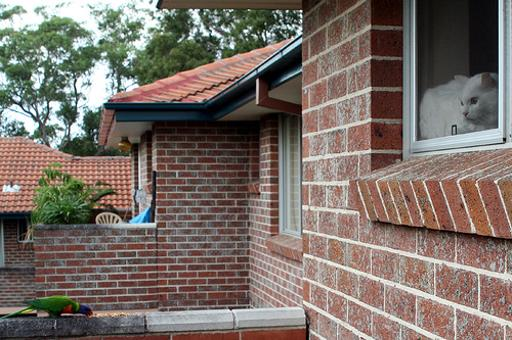

In [20]:
from IPython.display import Image
Image(filename=impath)

### Step 3: Text-to-Image Search

Now implement text-to-image-search.

The only difference here is that the query is a string of text. You will use the text encoder to obtain the corresponding query embedding.

Most similar image: coco_images_resized/COCO_train2014_000000447928.jpg


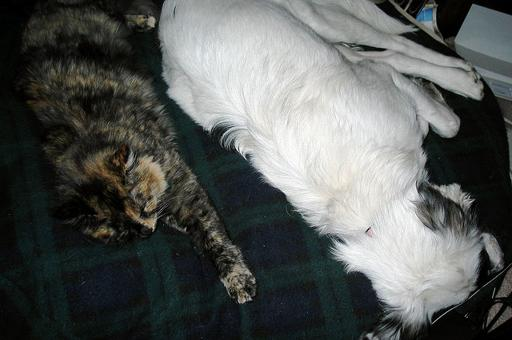

In [21]:
import open_clip

# Tokenize the text query
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model.eval()
text = tokenizer(["cat cuddles with dog on sofa."])

# Get the query embedding from the text encoder
with torch.no_grad():
    query_embedding = F.normalize(model.encode_text(text), p=2, dim=1)

# Convert query_embedding to a NumPy array
query_embedding_np = query_embedding.squeeze().detach().cpu().numpy()

# Convert DataFrame embeddings to a NumPy array for efficient computation
embeddings = np.stack(df['embedding'].to_numpy())

# Compute cosine similarities
cosine_similarities = np.dot(embeddings, query_embedding_np)

# Find the index of the maximum similarity
max_index = np.argmax(cosine_similarities)

# Retrieve the corresponding image path
impath = os.path.join(image_folder, df.iloc[max_index]['file_name'])
print(f"Most similar image: {impath}")

from IPython.display import Image
Image(filename=impath)

### Step 4:  Hybrid Query

A more interesting query could contain both image and text.

For example, instead of explicitly searching for an "image of snowy house", you could search for "snowy" + an image of a house.


In this case, you should embed both the text query and the image query. Then, the query embedding is a weighted average of the two embeddings.

Most similar image: coco_images_resized/COCO_train2014_000000296735.jpg


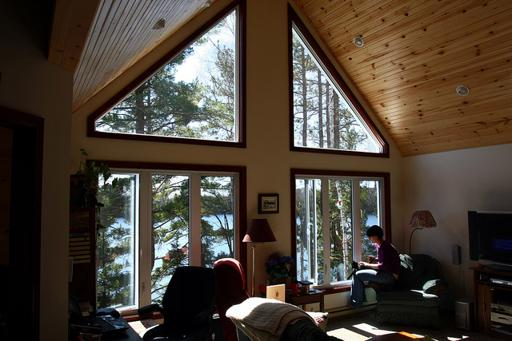

In [23]:
from PIL import Image
from IPython.display import Image as IPImage

# Load and preprocess the image query
image = preprocess(Image.open("house.jpg")).unsqueeze(0)
with torch.no_grad():
    image_query = F.normalize(model.encode_image(image), p=2, dim=1)

# Tokenize and embed the text query
text = tokenizer(["snowy"])  # Replace "snowy" with your desired text
with torch.no_grad():
    text_query = F.normalize(model.encode_text(text), p=2, dim=1)

# Combine text and image queries with a weighted average
lam = 0.8  # Adjust lambda to tune the weight of the text query
with torch.no_grad():
    query_embedding = F.normalize(lam * text_query + (1.0 - lam) * image_query, p=2, dim=1)

# Convert query_embedding to a NumPy array
query_embedding_np = query_embedding.squeeze().detach().cpu().numpy()

# Convert DataFrame embeddings to a NumPy array for efficient computation
embeddings = np.stack(df['embedding'].to_numpy())  # Shape: (num_images, embedding_dim)

# Compute cosine similarities
cosine_similarities = np.dot(embeddings, query_embedding_np)

# Find the index of the maximum similarity
max_index = np.argmax(cosine_similarities)

# Retrieve the corresponding image path
impath = os.path.join(image_folder, df.iloc[max_index]['file_name'])
print(f"Most similar image: {impath}")

# Display the most similar image
IPImage(filename=impath)
